In [1]:
import networkx as nx
from networkx.algorithms import community as com
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from scipy.cluster.hierarchy import dendrogram
from node2vec import Node2Vec

In [3]:
input_path = "./models/undirected_papper_colaboration.gml" 

G = nx.Graph(nx.read_gml(input_path)) 

In [5]:
autori_labele = G.nodes()
print(autori_labele)

['tanja jovanovic', 'branislava savic', 'sanja mitrovic', 'lazar ranin', 'valentina arsic-arsenijevic', 'slobodanka djukic', 'maja cupic', 'natasa vuckovic-opavski', 'aleksandar dzamic', 'dragana vukovic', 'ivana dakic', 'aleksandra knezevic', 'ivana lazarevic', 'maja stanojevic', 'vera mijac', 'ivana cirkovic', 'ivana colovic-colovski', 'ana banko', 'ina gajic', 'irena arandjelovic', 'eleonora dubljanin', 'dusan kekic', 'vera pravica', 'dusan popadic', 'vladimir trajkovic', 'milos markovic', 'emina milosevic', 'vladimir perovic', 'irena vukovic-petrovic', 'ljiljana markovic-denic', 'sandra sipetic-grujicic', 'tatjana pekmezovic', 'darija kisic-tepavcevic', 'jadranka maksimovic', 'natasa maksimovic', 'isidora vujcic', 'tatjana gazibara', 'gorica maric', 'vuk marusic', 'vladimir nikolic', 'jasmina simonovic-babic', 'milos korac', 'jovan ranin', 'branko milosevic', 'goran stevanovic', 'jasmina poluga', 'ksenija bojovic', 'ivana milosevic', 'aleksandra radovanovic-spurnic', 'nikola mitrov

In [7]:
L = nx.laplacian_matrix(G).todense()
eigenvalues, eigenvectors = np.linalg.eigh(L)

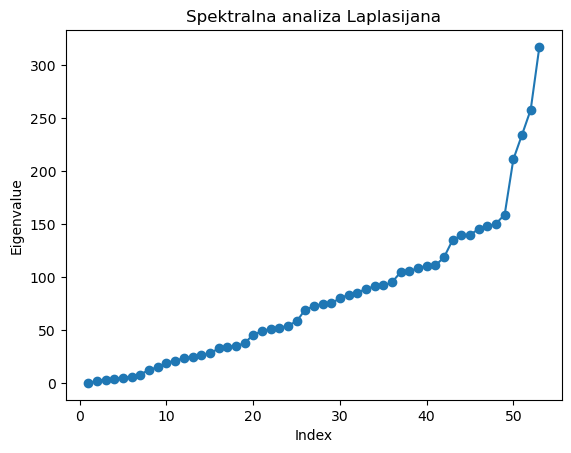

In [9]:
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spektralna analiza Laplasijana')
plt.show()

In [11]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])



Computing transition probabilities:   0%|          | 0/53 [00:00<?, ?it/s]

In [12]:
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

# Combine these into a feature matrix
embeddings = np.array([
    [degree[node], closeness[node], betweenness[node]] for node in G.nodes()
])

In [15]:
from sklearn.cluster import KMeans

num_clusters = 4 

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

community_dict = {node: labels[i] for i, node in enumerate(G.nodes())}
community_dict_str = {node: str(community_dict[node]) for node in community_dict}
nx.set_node_attributes(G, community_dict_str, 'community')


C:\Users\and\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [65]:
output_path="models/paper_colaboration_comunityK=4.gml"
nx.write_gml(G, output_path)

In [17]:
from itertools import chain, combinations

In [19]:
communities = list(nx.community.girvan_newman(G))
# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank


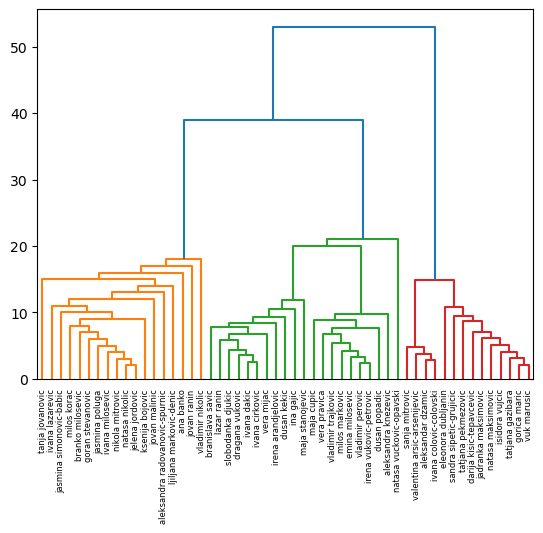

In [21]:

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
plt.savefig('dendrogram.png')